# Plotting cycle to work times

In [66]:
#!pip install HASS-data-detective # Install detective

In [67]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [68]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 296 entities with data


First we extract all state changes for Gaby and Charles

In [69]:
people = ("person.charles","person.gaby",)
workplaces = ("Imperial", "Harris Westminster",)
results = db.fetch_all_data_of(people)
results.last_changed = pd.to_datetime(results.last_changed)
results.set_index('last_changed', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

The returned Pandas dataframe has 29952 rows of data.


,domain,entity_id,state,attributes
time,,,,
2021-11-29 17:46:13.769858,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.41..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.42..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.43..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.46..."
...,...,...,...,...
2022-02-23 09:00:09.403959,person,person.charles,Imperial,"{""editable"":false,""id"":""charles"",""latitude"":51..."
2022-02-23 09:00:09.403959,person,person.charles,Imperial,"{""editable"":false,""id"":""charles"",""latitude"":51..."
2022-02-23 09:00:09.403959,person,person.charles,Imperial,"{""editable"":false,""id"":""charles"",""latitude"":51..."


In [70]:
results['time'] = results.index
results = results.drop_duplicates(subset=('domain', 'entity_id', 'state', 'time')).drop(['time', 'attributes'], axis=1)
results

,domain,entity_id,state
time,,,
2021-11-29 17:46:13.769858,person,person.gaby,home
2021-11-30 07:51:31.218973,person,person.gaby,not_home
2021-11-30 08:12:10.004068,person,person.charles,not_home
2021-11-30 08:35:23.349953,person,person.gaby,Harris Westminster
2021-11-30 09:05:18.560750,person,person.charles,Imperial
...,...,...,...
2022-02-23 08:11:18.961058,person,person.gaby,Central london
2022-02-23 08:26:41.385600,person,person.charles,not_home
2022-02-23 08:38:28.759979,person,person.gaby,Harris Westminster


Let's collect all journeys made between home and work and plot their times. 

In [71]:
journeys = {person: pd.Series() for person in people}
for person, workplace in zip(people, workplaces):
    state_changes = results.loc[results.entity_id == person, 'state']
    for i in range(state_changes.shape[0]):
        if state_changes.iloc[i] == "home":
            try:
                for j in range(i+1, i+10):                
                    if state_changes.iloc[j] == workplace:
                        time_taken = state_changes.index[j] - state_changes.index[i+1]
                        journeys[person][state_changes.index[i+1]] = time_taken
                        break
            except IndexError:
                break
journeys

/tmp/ipykernel_590/771486441.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  journeys = {person: pd.Series() for person in people}


{'person.charles': 2021-12-01 07:57:35.007636   0 days 00:50:40.043258
 2021-12-01 08:21:09.399516   0 days 00:27:05.651378
 2021-12-04 22:05:06.231756   1 days 11:14:37.987962
 2021-12-05 10:43:00.004677   0 days 22:36:44.215041
 2021-12-05 15:56:53.686584   0 days 17:22:50.533134
                                       ...          
 2022-02-19 17:59:25.308511   1 days 14:28:15.262488
 2022-02-21 07:46:00.023187   0 days 00:41:40.547812
 2022-02-22 08:30:45.004486   0 days 01:12:39.741364
 2022-02-22 09:04:40.127216   0 days 00:38:44.618634
 2022-02-23 08:26:41.385600   0 days 00:33:28.018359
 Length: 74, dtype: timedelta64[ns],
 'person.gaby': 2021-11-30 07:51:31.218973   0 days 00:43:52.130980
 2021-12-01 07:50:55.005667   0 days 00:45:59.463352
 2021-12-01 17:52:40.006965   0 days 14:53:51.386767
 2021-12-01 19:27:00.006600   0 days 13:19:31.387132
 2021-12-02 08:01:20.007401   0 days 00:45:11.386331
                                       ...          
 2022-02-19 11:11:11.796257  

Assume that all journeys take between 20 mins and 2 hours.

In [72]:
for person, data in journeys.items():
    journeys[person] = data[(pd.Timedelta("20m") < data) & (data < pd.Timedelta("2h"))]

Store by day, as dataframe

<AxesSubplot:title={'center':'Time taken for morning commute'}, ylabel='Time / min'>

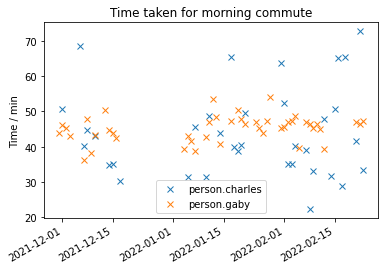

In [75]:
for person, data in journeys.items():
    data.index = data.index.round("D")
    journeys[person] = data[~data.index.duplicated()]
journeys = pd.DataFrame(journeys)
(journeys / pd.Timedelta("1m")).plot(
    ylabel="Time / min",
    title="Time taken for morning commute",
    style='x'
)

In [76]:
def extract_journey_times()

,person.charles,person.gaby
2021-11-30,NaT,0 days 00:43:52.130980
2021-12-01,0 days 00:50:40.043258,0 days 00:45:59.463352
2021-12-02,NaT,0 days 00:45:11.386331
2021-12-03,NaT,0 days 00:43:07.270770
2021-12-06,0 days 01:08:19.214911,NaT
2021-12-07,0 days 00:40:16.763523,0 days 00:36:13.190228
2021-12-08,0 days 00:44:34.046320,0 days 00:47:44.088594
2021-12-09,NaT,0 days 00:38:05.660430
2021-12-10,0 days 00:43:02.572110,0 days 00:43:11.342344
2021-12-13,NaT,0 days 00:50:15.328061


At some point, I added Wimbledon as a location so that I could distuinguish between train and bike journeys. When was this?